### Binary classification of X-ray image series

W tym modelu tworzone są serie 4 syntetycznych obrazów zawierających rozmyte i nieregularne okręgi lub elipsy (nazwałem te obrazy "helthy" i "sick"). Na pierwszym obrazie jest jeden obiekt, na drugim dwa itd. Zadaniem jest klasyfikacja całej serii obrazów.

Klasyfikacja dokonywana jest za pomocą pretrenowanej sieci Xception, wyniki są zbierane w jeden wektor za pomocą warstwy layers.TimeDistributed i potem layers.GlobalAveragePooling1D() oraz GlobalMaxPooling1D. Można zastosować także tylko jeden z typów pooling lub wogóle zrezygnować z pooling i użyć wszystkich zmiennych wyjściowych z czterech sieci Xception używając funkcji flatten. Celem uniknięcia przetrenowania zastosowano augmentację danych poprzez dodanie warstw augmentacji przed wejściem sieci Xception.

Wykomentowana jest prosta sieć CNN którą można zastąpić sieć Xception. Daje też sensowne wyniki.

Listopad 2025, Marcin Wolter i claude.ai :)


In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0


In [2]:
# ============================================
# Step 1: Create Artificial Data
# ============================================
# Simulating series of X-ray images (e.g., chest X-rays from different angles)
# Each series contains 4 images of size 224x224x3

NUM_SERIES = 2000  # Total number of image series
IMAGES_PER_SERIES = 4  # Number of images in each series (e.g., 4 different angles)
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def generate_artificial_series(num_series, images_per_series, label):
    """
    Generate artificial image series with subtle differences.
    For 'healthy' (label=0): images with irregular circles (smeared, noisy)
        - Image 1: 1 irregular circle
        - Image 2: 2 irregular circles
        - Image 3: 3 irregular circles
        - Image 4: 4 irregular circles
    For 'sick' (label=1): images with irregular ellipses (smeared, noisy)
        - Image 1: 1 irregular ellipse
        - Image 2: 2 irregular ellipses
        - Image 3: 3 irregular ellipses
        - Image 4: 4 irregular ellipses
    
    Both have similar levels of noise and irregularity to make classification challenging.
    """
    series_data = []
    
    for _ in range(num_series):
        series = []
        for img_idx in range(images_per_series):
            # Create base image with light background and noise
            img = np.ones((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) * 0.85
            img += np.random.randn(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS) * 0.08
            
            # Number of shapes increases with each image in the series
            num_shapes = img_idx + 1
            
            if label == 0:  # healthy - irregular circles
                for _ in range(num_shapes):
                    # Random position
                    x_center = np.random.randint(50, IMG_WIDTH - 50)
                    y_center = np.random.randint(50, IMG_HEIGHT - 50)
                    radius = np.random.randint(20, 40)
                    
                    # Create meshgrid
                    yy, xx = np.ogrid[:IMG_HEIGHT, :IMG_WIDTH]
                    distance = np.sqrt((xx - x_center)**2 + (yy - y_center)**2)
                    
                    # Soft circle with irregularities
                    circle = np.exp(-(distance - radius)**2 / (2 * (radius * 0.3)**2))
                    
                    # Add irregularities using Perlin-like noise
                    noise_x = np.sin(xx * 0.05 + np.random.uniform(0, 2*np.pi)) * np.cos(yy * 0.05 + np.random.uniform(0, 2*np.pi))
                    noise_y = np.cos(xx * 0.07 + np.random.uniform(0, 2*np.pi)) * np.sin(yy * 0.07 + np.random.uniform(0, 2*np.pi))
                    irregularity = (noise_x + noise_y) * 0.3
                    
                    circle = circle * (1 + irregularity)
                    circle = np.clip(circle, 0, 1)
                    
                    # Add smearing effect (motion blur simulation)
                    from scipy.ndimage import gaussian_filter
                    circle = gaussian_filter(circle, sigma=np.random.uniform(1.5, 3.0))
                    
                    # Apply to image
                    color = np.random.uniform(0.15, 0.35)
                    for c in range(IMG_CHANNELS):
                        img[:, :, c] = img[:, :, c] * (1 - circle * 0.7) + color * circle * 0.7
                        
            else:  # sick - irregular ellipses (elongated circles)
                for _ in range(num_shapes):
                    # Random position
                    x_center = np.random.randint(50, IMG_WIDTH - 50)
                    y_center = np.random.randint(50, IMG_HEIGHT - 50)
                    
                    # Ellipse parameters - elongated in one direction
                    radius_major = np.random.randint(30, 50)  # Longer axis
                    radius_minor = np.random.randint(20, 30)  # Shorter axis
                    angle = np.random.uniform(0, np.pi)  # Rotation angle
                    
                    # Create meshgrid
                    yy, xx = np.ogrid[:IMG_HEIGHT, :IMG_WIDTH]
                    
                    # Rotate coordinates
                    xx_rot = (xx - x_center) * np.cos(angle) + (yy - y_center) * np.sin(angle)
                    yy_rot = -(xx - x_center) * np.sin(angle) + (yy - y_center) * np.cos(angle)
                    
                    # Ellipse equation
                    distance_ellipse = np.sqrt((xx_rot / radius_major)**2 + (yy_rot / radius_minor)**2)
                    
                    # Soft ellipse
                    ellipse = np.exp(-(distance_ellipse - 1)**2 / (2 * 0.3**2))
                    
                    # Add irregularities (same as circles for fairness)
                    noise_x = np.sin(xx * 0.05 + np.random.uniform(0, 2*np.pi)) * np.cos(yy * 0.05 + np.random.uniform(0, 2*np.pi))
                    noise_y = np.cos(xx * 0.07 + np.random.uniform(0, 2*np.pi)) * np.sin(yy * 0.07 + np.random.uniform(0, 2*np.pi))
                    irregularity = (noise_x + noise_y) * 0.3
                    
                    ellipse = ellipse * (1 + irregularity)
                    ellipse = np.clip(ellipse, 0, 1)
                    
                    # Add smearing effect (same as circles)
                    from scipy.ndimage import gaussian_filter
                    ellipse = gaussian_filter(ellipse, sigma=np.random.uniform(1.5, 3.0))
                    
                    # Apply to image
                    color = np.random.uniform(0.15, 0.35)
                    for c in range(IMG_CHANNELS):
                        img[:, :, c] = img[:, :, c] * (1 - ellipse * 0.7) + color * ellipse * 0.7
            
            # Add additional overall noise and artifacts
            img += np.random.randn(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS) * 0.05
            
            # Clip to [0, 1]
            img = np.clip(img, 0, 1)
            series.append(img)
        
        series_data.append(np.array(series))
    
    return np.array(series_data)

# Generate data
print("Generating artificial data...")
healthy_series = generate_artificial_series(NUM_SERIES // 2, IMAGES_PER_SERIES, label=0)
sick_series = generate_artificial_series(NUM_SERIES // 2, IMAGES_PER_SERIES, label=1)

# Combine and create labels
X = np.vstack([healthy_series, sick_series])
y = np.array([0] * (NUM_SERIES // 2) + [1] * (NUM_SERIES // 2))

print(f"Data shape: {X.shape}")  # (2000, 4, 224, 224, 3)
print(f"Labels shape: {y.shape}")  # (2000,)


Generating artificial data...
Data shape: (2000, 4, 224, 224, 3)
Labels shape: (2000,)



Visualizing generated data...

Generated data visualization saved as 'generated_data_visualization.png'


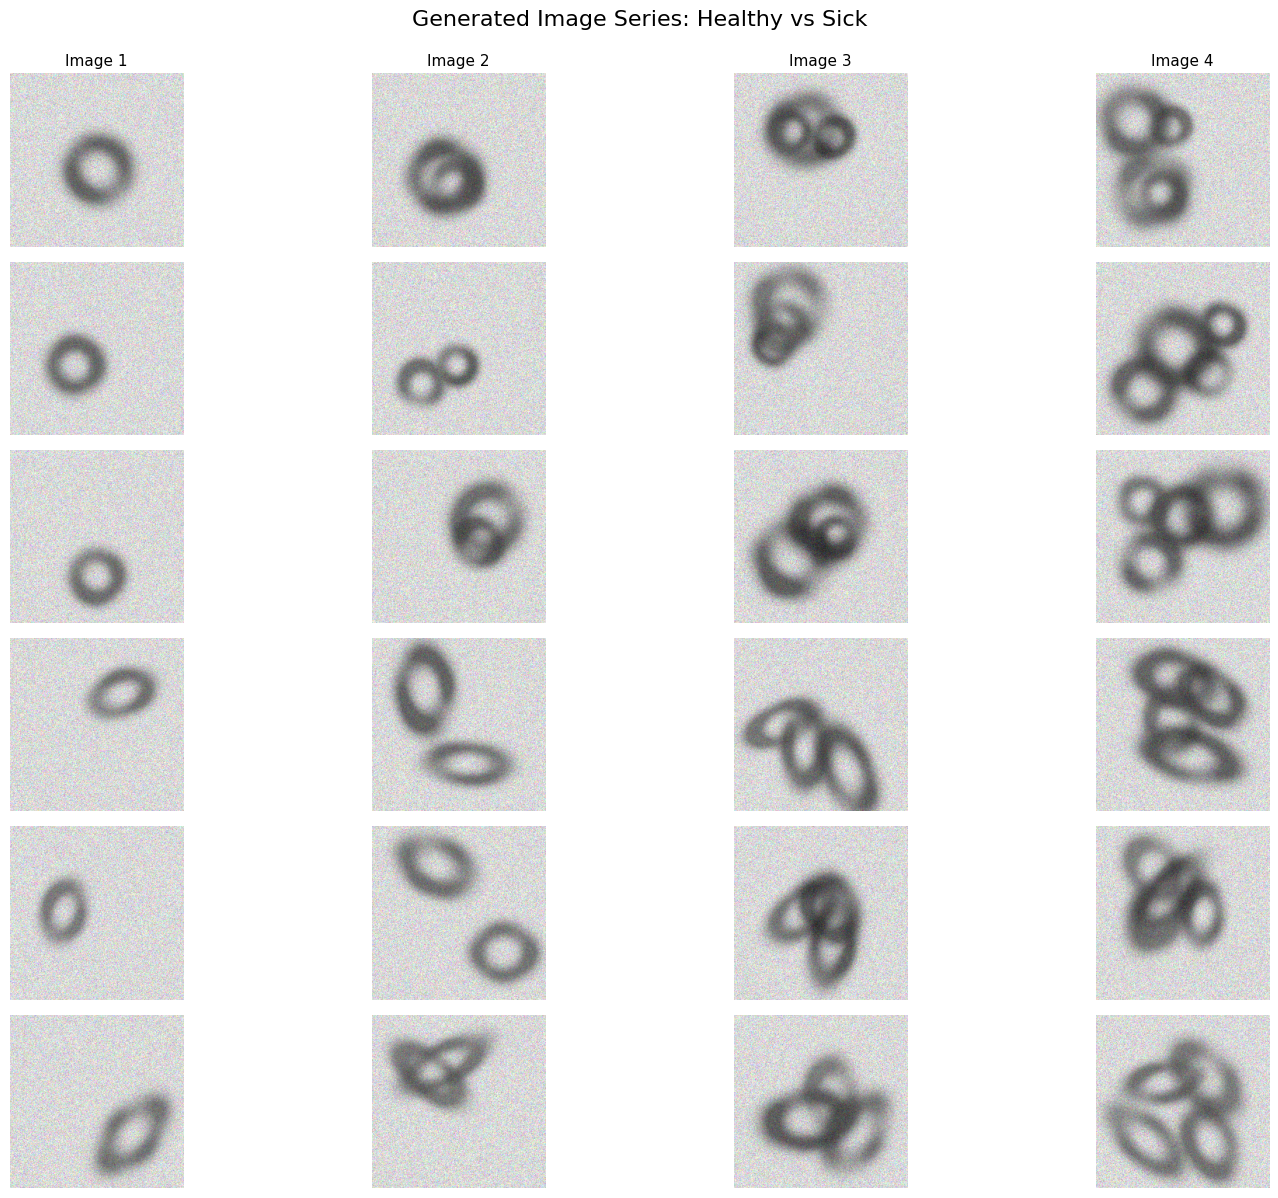

In [3]:
# ============================================
# Visualize Generated Data
# ============================================
def visualize_generated_series(healthy_data, sick_data, num_series=3):
    """
    Display sample series from both healthy and sick categories.
    
    Args:
        healthy_data: Array of healthy image series
        sick_data: Array of sick image series
        num_series: Number of series to display from each category
    """
    fig, axes = plt.subplots(num_series * 2, IMAGES_PER_SERIES, 
                             figsize=(16, 4 * num_series))
    fig.suptitle('Generated Image Series: Healthy vs Sick', fontsize=16, y=0.995)
    
    # Display healthy series
    for i in range(num_series):
        for j in range(IMAGES_PER_SERIES):
            ax = axes[i, j]
            ax.imshow(healthy_data[i, j])
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f'Healthy\nSeries {i+1}', 
                            fontsize=12, rotation=0, 
                            labelpad=50, va='center')
            if i == 0:
                ax.set_title(f'Image {j+1}', fontsize=11)
    
    # Display sick series
    for i in range(num_series):
        for j in range(IMAGES_PER_SERIES):
            ax = axes[num_series + i, j]
            ax.imshow(sick_data[i, j])
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f'Sick\nSeries {i+1}', 
                            fontsize=12, rotation=0, 
                            labelpad=50, va='center', 
                            color='red')
            if i == 0 and num_series == 0:
                ax.set_title(f'Image {j+1}', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('generated_data_visualization.png', dpi=300, bbox_inches='tight')
    print("\nGenerated data visualization saved as 'generated_data_visualization.png'")
    plt.show()

print("\nVisualizing generated data...")
visualize_generated_series(healthy_series, sick_series, num_series=3)


In [4]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1600, Test samples: 400


In [5]:
# Calculate class weights to handle any imbalance
# We have no imbalance here, just for the future use.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.0, 1: 1.0}


In [ ]:
# ============================================
# Step 2: Build the Model
# ============================================

def create_series_classifier():
    """
    Use ResNet50 as frozen feature extractor, train only the classification head.
    """
    
    # Input: series of images
    series_input = layers.Input(shape=(IMAGES_PER_SERIES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Moderate augmentation
    data_augmentation = keras.Sequential([
        layers.RandomRotation(0.15),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.1),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
    ])
    
    # Apply augmentation
    augmented = layers.TimeDistributed(data_augmentation)(series_input)
    
    # Load pretrained Xception - COMPLETELY FROZEN
    #base_model = keras.applications.ResNet50( # I had problems with ResNet50, Xception works better
    base_model = keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        pooling='avg'
    )
    
    # Freeze ALL layers
    base_model.trainable = False
    
    # Process each image with Xception
    features = layers.TimeDistributed(base_model)(augmented)
    
    # Aggregate features across the series - use BOTH avg and max
    avg_features = layers.GlobalAveragePooling1D()(features)
    max_features = layers.GlobalMaxPooling1D()(features)
    combined = layers.Concatenate()([avg_features, max_features])
    
    # Moderate classification head
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=series_input, outputs=output)
    
    return model

In [ ]:

print("\nBuilding model...")
model = create_series_classifier()
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),  # low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Add learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.000001,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True
)

# Add after early_stopping callback definition
class PredictionMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            preds = self.model.predict(X_train[:20], verbose=0)
            pred_labels = (preds > 0.5).astype(int).flatten()
            true_labels = y_train[:20]
            print(f"\nEpoch {epoch} - Sample predictions: {pred_labels[:10]}")
            print(f"Epoch {epoch} - True labels:        {true_labels[:10]}")
            #print(f"Epoch {epoch} - Prediction mean: {preds.mean():.3f}")

prediction_monitor = PredictionMonitor()

# Update callbacks
#callbacks=[reduce_lr, prediction_monitor]




Building model...


I0000 00:00:1762684481.981014 2241201 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762684482.013619 2241201 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762684482.014870 2241201 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1762684482.017956 2241201 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 224,    │          0 │ input_layer[0][0] │
│ (TimeDistributed)   │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 2048)   │ 20,861,480 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ time_distributed… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,394,729 (81.61 MB)

 Trainable params: 532,993 (2.03 MB)

 Non-trainable params: 20,861,736 (79.58 MB)

In [8]:

# ============================================
# Step 3: Train the Model
# ============================================
print("\nTraining model...")



history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    #validation_split=0.2,
    epochs=200,  # More epochs
    batch_size=16,  # Larger batch size
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, prediction_monitor, early_stopping],
    verbose=1
)



Training model...
Epoch 1/200


W0000 00:00:1762684497.760627 2241406 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.762882 2241393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.763053 2241398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.763196 2241405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.792257 2241393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.792471 2241398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.792973 2241405 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.793645 2241406 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684497.793995 2241393 gp

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5077 - auc: 0.5221 - loss: 1.2027

W0000 00:00:1762684516.676596 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.677138 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.677619 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.678127 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.678631 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.679135 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.679638 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.680224 2241409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762684516.680818 2241409 gp


Epoch 0 - Sample predictions: [0 1 0 0 1 0 0 0 0 1]
Epoch 0 - True labels:        [1 1 0 0 1 0 1 0 0 1]
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.5082 - auc: 0.5227 - loss: 1.2019 - val_accuracy: 0.6375 - val_auc: 0.7458 - val_loss: 0.9880 - learning_rate: 1.0000e-05
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.6360 - auc: 0.7117 - loss: 0.9760 - val_accuracy: 0.7725 - val_auc: 0.8933 - val_loss: 0.9005 - learning_rate: 1.0000e-05
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.7138 - auc: 0.8026 - loss: 0.8671 - val_accuracy: 0.8450 - val_auc: 0.9277 - val_loss: 0.8027 - learning_rate: 1.0000e-05
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7801 - auc: 0.8635 - loss: 0.7864 - val_accuracy: 0.8750 - val_auc: 0.9464 - val_loss: 0.7182 - learning_rate: 1.0000e-05
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.8116 - auc: 0.8834 - loss: 0.7607 - val_accuracy: 0.8775 - val_auc: 0

In [9]:

# ============================================
# Step 4: Evaluate the Model
# ============================================
print("\nEvaluating model...")

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Sick']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Test accuracy
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Train accuracy
train_loss, train_acc, train_auc = model.evaluate(X_train, y_train, verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}")




Evaluating model...


W0000 00:00:1762686944.736635 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.737281 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.737861 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.738449 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.739039 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.739634 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.740223 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.740976 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.741729 2241402 gp

 1/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step

W0000 00:00:1762686944.937952 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.938592 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.939234 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.939896 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.940536 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.941392 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.942080 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.942798 2241402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762686944.943474 2241402 gp

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       200
        Sick       0.99      0.97      0.98       200

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.98      0.98       400


Confusion Matrix:
[[199   1]
 [  5 195]]

Test Accuracy: 0.9850
Test AUC: 0.9990

Train Accuracy: 0.9869
Train AUC: 0.9994


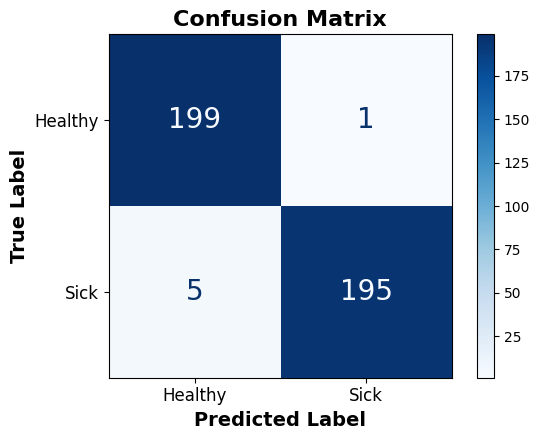

In [13]:
# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 4.5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=['Healthy', 'Sick'],
    cmap='Blues',
    ax=ax,
    colorbar=True
)

# Customize font sizes
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', labelsize=12)

# Make the numbers in cells bigger
for text in ax.texts:
    text.set_fontsize(20)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Training history saved as 'training_history.png'


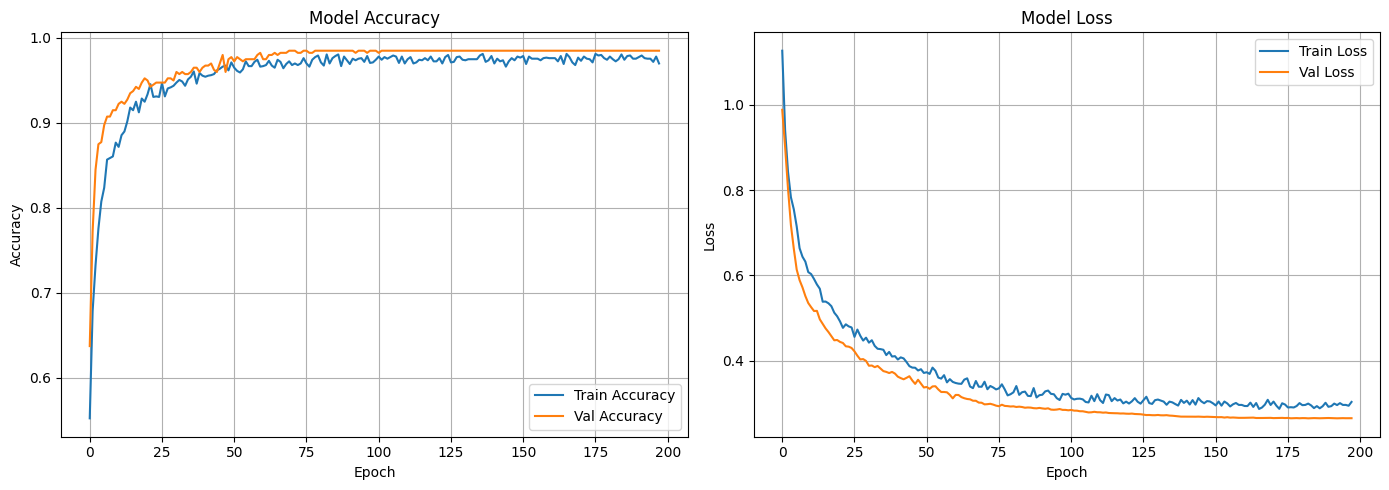

Sample predictions saved as 'sample_predictions.png'


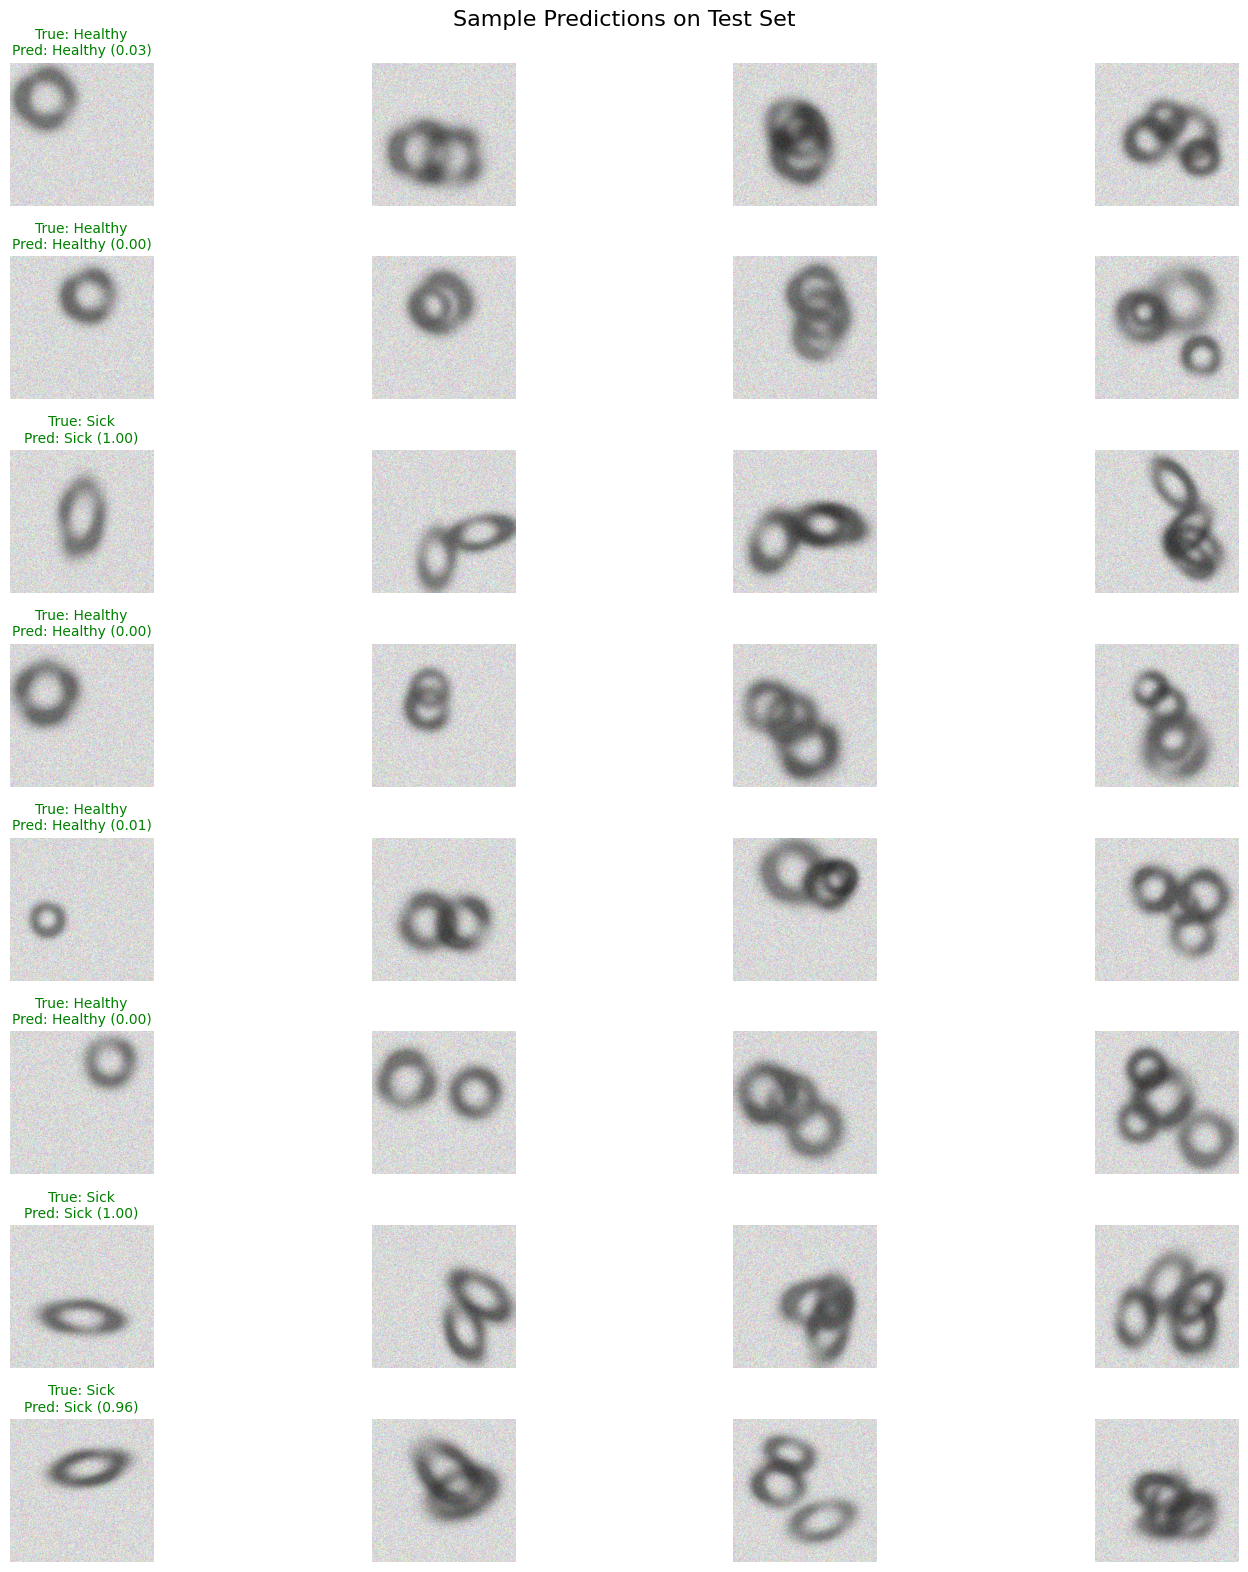


Model training and evaluation complete!


In [15]:

# ============================================
# Step 5: Visualize Results
# ============================================
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("\nTraining history saved as 'training_history.png'")
plt.show()

# Visualize sample predictions
nrows = 8
fig, axes = plt.subplots(nrows, 4, figsize=(16, 16))
fig.suptitle('Sample Predictions on Test Set', fontsize=16)

for i in range(nrows):
    sample_idx = np.random.randint(0, len(X_test))
    series = X_test[sample_idx]
    true_label = y_test[sample_idx]
    pred_proba = y_pred_proba[sample_idx][0]
    pred_label = int(pred_proba > 0.5)
    
    for j in range(4):
        axes[i, j].imshow(series[j])
        axes[i, j].axis('off')
        if j == 0:
            color = 'green' if pred_label == true_label else 'red'
            axes[i, j].set_title(
                f"True: {'Sick' if true_label == 1 else 'Healthy'}\n"
                f"Pred: {'Sick' if pred_label == 1 else 'Healthy'} ({pred_proba:.2f})",
                color=color, fontsize=10
            )

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
print("Sample predictions saved as 'sample_predictions.png'")
plt.show()

print("\n" + "="*50)
print("Model training and evaluation complete!")
print("="*50)